# Setup

In [73]:
import pandapower.networks as pnet
import pandas as pd
import numpy as np
import scipy as sp
import cvxpy as cp
import seaborn as sns
import mlflow

from scipy import sparse
import matplotlib.pyplot as plt

/Users/jbrouill/PycharmProjects/eiv-grid-id/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
../src/models/error_in_variable.py:174: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  z = [(1/(i + self.cons_multiplier_step_size) if i is not 0 else 0) for i in y]


In [74]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [75]:
import sys
sys.path.insert(1, '..')

from src.models.matrix_operations import make_real_vector, vectorize_matrix
from src.simulation.noise import add_polar_noise_to_measurement
from src.models.regression import ComplexRegression, ComplexLasso
from src.models.error_in_variable import TotalLeastSquares, SparseTotalLeastSquare
from src.simulation.load_profile import generate_gaussian_load
from src.simulation.network import add_load_power_control, make_y_bus
from src.simulation.simulation import run_simulation, get_current_and_voltage
from src.identification.error_metrics import error_metrics, fro_error
from src.models.noise_transformation import average_true_noise_covariance,exact_noise_covariance

# Network simulation

In [76]:
mlflow.set_experiment('Full network with polar noise')

In [77]:
net = pnet.create_kerber_landnetz_freileitung_2()
nodes = net.bus.shape[0]
steps = 400
load_cv = 0.2
current_magnitude_sd = 0.000001
voltage_magnitude_sd = 0.0001
phase_sd = 0.0001

In [78]:
np.random.seed(11)
load_p, load_q = generate_gaussian_load(net.load.p_mw, net.load.q_mvar, load_cv, steps)
controlled_net = add_load_power_control(net, load_p, load_q)
sim_result = run_simulation(controlled_net, verbose=False)
y_bus = make_y_bus(controlled_net)
voltage, current = get_current_and_voltage(sim_result, y_bus)
controlled_net.bus

No time steps to calculate are specified. I'll check the datasource of the first controller for avaiable time steps


,name,vn_kv,type,zone,in_service
0,Trafostation_OS,10.0,b,None,True
1,main_busbar,0.4,b,None,True
2,bus_1_1,0.4,b,None,True
3,bus_1_2,0.4,b,None,True
4,bus_1_3,0.4,b,None,True
5,bus_1_4,0.4,b,None,True
6,bus_1_5,0.4,b,None,True
7,bus_1_6,0.4,b,None,True
8,bus_2_1,0.4,b,None,True
9,bus_2_2,0.4,b,None,True


In [79]:
voltage = voltage[:, 1:]
#print(y_bus)
y_v = y_bus[1,0]
y_bus = y_bus[1:, 1:]
y_bus[0,0] = y_bus[0,0] + y_v
current = np.array(voltage @ y_bus)
noisy_voltage = add_polar_noise_to_measurement(voltage, voltage_magnitude_sd, phase_sd)
noisy_current = add_polar_noise_to_measurement(current, current_magnitude_sd, phase_sd)
voltage_error, current_error = noisy_voltage - voltage, noisy_current - current

/Users/jbrouill/PycharmProjects/eiv-grid-id/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [80]:
np.linalg.svd(voltage, compute_uv=False)

array([5.89221591e+01, 4.25232562e-02, 1.35369650e-02, 5.73441653e-03,
       2.75443540e-03, 2.25199217e-03, 1.55263364e-03, 1.16434339e-03,
       9.41492168e-04])

In [81]:
np.mean(np.abs(current), 0)

array([0.06559741, 0.00810926, 0.00811186, 0.00817258, 0.00823941,
       0.00830128, 0.00824192, 0.00803008, 0.0081679 ])

In [82]:
mlflow_params = {
    'nodes': noisy_voltage.shape[1],
    'steps': steps, 
    'load_cv': load_cv, 
    'current_magnitude_sd': current_magnitude_sd, 
    'voltage_magnitude_sd': voltage_magnitude_sd,
    'phase_sd': phase_sd
}

# OLS Identification

In [83]:
with mlflow.start_run(run_name='OLS'):
    ols = ComplexRegression()
    ols.fit(noisy_voltage, noisy_current)
    y_ols = ols.fitted_admittance_matrix
    ols_metrics = error_metrics(y_bus, y_ols)
    mlflow.log_params(mlflow_params)
    mlflow.log_metrics(ols_metrics.__dict__)
ols_metrics

ErrorMetrics(fro_error=46.39067258258446, max_error=15.376834960569314, rrms_error=0.8105628504223067, map_error=0.7781759858766334)

# Lasso Identification

In [84]:
with mlflow.start_run(run_name='Lasso'):
    lasso = ComplexLasso(y_bus, verbose=False, lambdas=np.logspace(-12, -1, 40), solver=cp.GUROBI)
    lasso.fit(noisy_voltage, noisy_current)
    y_lasso = lasso.fitted_admittance_matrix
    lasso_metrics = error_metrics(y_bus, y_lasso)
    mlflow.log_params(mlflow_params)
    mlflow.log_metrics(lasso_metrics.__dict__)
best_lambda = lasso.best_trial.hyperparameters['lambda']
lasso_metrics

/Users/jbrouill/PycharmProjects/eiv-grid-id/venv/lib/python3.8/site-packages/cvxpy/reductions/solvers/solving_chain.py:323: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  return self.solver.solve_via_data(data, warm_start, verbose,


ErrorMetrics(fro_error=46.390672601914886, max_error=15.376835003240718, rrms_error=0.8105628507600584, map_error=0.7781759852448075)

In [85]:
best_lambda

1.8047217668271666e-10

# TLS Identification

In [86]:
with mlflow.start_run(run_name='TLS'):
    tls = TotalLeastSquares()
    tls.fit(noisy_voltage, noisy_current)
    y_tls = tls.fitted_admittance_matrix
    tls_metrics = error_metrics(y_bus, y_tls)
    mlflow.log_params(mlflow_params)
    mlflow.log_metrics(tls_metrics.__dict__)
tls_metrics

[[-0.03088995+0.00221144j -0.00566458-0.04227946j -0.02447462+0.00923283j
   0.01895968-0.00166987j  0.02561265-0.01622336j -0.09175648-0.03567287j
  -0.06065055+0.00960882j  0.13908049-0.01697422j -0.30857205+0.12662023j]
 [-0.01123044+0.01827132j -0.02016472-0.04895954j -0.01295712-0.01650704j
  -0.03511262-0.03311281j  0.03686505-0.02846825j -0.07600929-0.03769754j
  -0.07499897+0.01642118j  0.04628065-0.0002546j  -0.30853835+0.12652878j]
 [ 0.03793267+0.025211j   -0.01804795-0.01119043j -0.01797233-0.04344747j
  -0.03200676-0.02779845j  0.02440623-0.02299796j -0.03545597-0.0061382j
  -0.07843895+0.00366525j -0.03977811+0.00440757j -0.30852257+0.12636572j]
 [ 0.02237623+0.03109122j -0.01230499+0.02759843j -0.01089585-0.02502235j
  -0.01829649+0.00494489j  0.01746949+0.00991868j  0.00710556+0.01057642j
  -0.05950832+0.00614294j -0.13242336+0.02012916j -0.30835805+0.12611661j]
 [ 0.00482879+0.02308155j  0.00602491+0.02279022j  0.00638018-0.00249786j
  -0.00456704+0.00539419j -0.046348

ErrorMetrics(fro_error=14.882138901540058, max_error=4.1675933607706455, rrms_error=0.2600287570079669, map_error=0.12232858632359919)

# L1 Regularized TLS

normalizing currents

In [189]:
with mlflow.start_run(run_name='S-TLS with covariance'):
    max_iterations = 1500
    abs_tol = 0.0000001
    rel_tol = 10e-15
    solver = cp.GUROBI
    use_cov_matrix = True
    pen_degree=1.0
    tls_weights_adaptive = np.divide(1.0, np.power(np.abs(make_real_vector(vectorize_matrix(y_tls))), 1.0))
    
    
    sigma_voltage = average_true_noise_covariance(noisy_voltage, voltage_magnitude_sd, phase_sd)
    sigma_current = average_true_noise_covariance(noisy_current, current_magnitude_sd, phase_sd)
    
    #sigma_voltage = exact_noise_covariance(voltage, voltage_magnitude_sd, phase_sd)
    #sigma_current = exact_noise_covariance(current, current_magnitude_sd, phase_sd)

    #inv_sigma_current = sparse.linalg.inv(sigma_current)
    #inv_sigma_voltage = sparse.linalg.inv(sigma_voltage)
    
    sparse_tls_cov = SparseTotalLeastSquare(lambda_value=100, abs_tol=abs_tol, rel_tol=rel_tol, solver=solver, max_iterations=max_iterations)
    sparse_tls_cov.l1_multiplier_step_size = 0.5
    sparse_tls_cov.cons_multiplier_step_size = 0.01
    #sparse_tls_cov.set_prior(make_real_vector(vectorize_matrix(np.zeros(y_tls.shape))), SparseTotalLeastSquare.LAPLACE,
    #                         np.diag(tls_weights_adaptive))

    sparse_tls_cov.l1_target = 2*np.count_nonzero(y_bus)
    sparse_tls_cov.l1_target = 1.0*(np.sum(np.power(np.abs(np.real(y_bus)),pen_degree))
                                    + np.sum(np.power(np.abs(np.imag(y_bus)),pen_degree)))
    sparse_tls_cov.l1_target = 1.0*2*np.sum(np.abs(make_real_vector(np.diag(y_tls))))

    sparse_tls_cov.fit(noisy_voltage, noisy_current, inv_sigma_voltage, inv_sigma_current, y_init=y_tls)
    
    y_sparse_tls_cov = sparse_tls_cov.fitted_admittance_matrix
    sparse_tls_cov_metrics = error_metrics(y_bus, y_sparse_tls_cov)
    
    sparse_tls_cov_errors = pd.Series([fro_error(y_bus, i.fitted_parameters) for i in sparse_tls_cov.iterations])
    sparse_tls_cov_targets = pd.Series([i.target_function for i in sparse_tls_cov.iterations])
    
    mlflow.log_param('lambda', best_lambda)
    mlflow.log_param('max_iterations', max_iterations)
    mlflow.log_param('abs_tol', abs_tol)
    mlflow.log_param('rel_tol', rel_tol)
    mlflow.log_param('solver', solver)
    mlflow.log_param('use_cov_matrix', use_cov_matrix)
    mlflow.log_params(mlflow_params)
    mlflow.log_metrics(sparse_tls_cov_metrics.__dict__)

    for i in range(len(sparse_tls_cov_errors)):
        mlflow.log_metric('fro_error_evo', value=sparse_tls_cov_errors[i], step=i)
        mlflow.log_metric('opt_cost_evo', value=sparse_tls_cov_targets[i], step=i)

/Users/jbrouill/PycharmProjects/eiv-grid-id/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
../src/models/error_in_variable.py:174: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  z = np.array([(1/(i + self.cons_multiplier_step_size) if i is not 0 else 0) for i in y])
  0%|          | 0/1500 [00:00<?, ?it/s]/Users/jbrouill/PycharmProjects/eiv-grid-id/venv/lib/python3.8/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:144: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',
100%|██████████| 1500/1500 [01:06<00:00, 22.40it/s]


<AxesSubplot:>

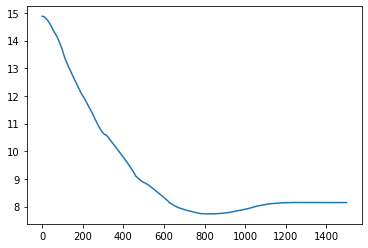

In [190]:
sparse_tls_cov_errors.plot()
#sparse_tls_cov_targets.copy().multiply(0.00004).plot()


/Users/jbrouill/PycharmProjects/eiv-grid-id/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:>

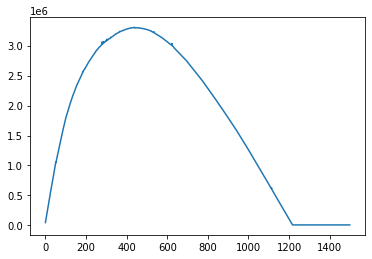

In [191]:
sparse_tls_cov_targets.plot()

/Users/jbrouill/PycharmProjects/eiv-grid-id/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


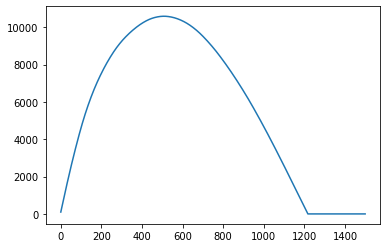

In [192]:
plt.plot(sparse_tls_cov.tmp)

# Result analysis

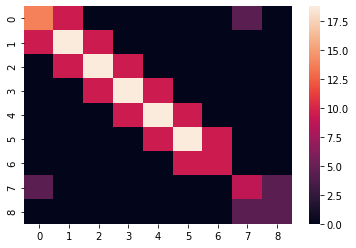

In [193]:
sns.heatmap(np.abs(y_bus));

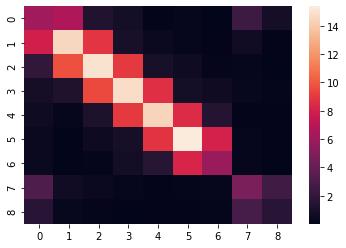

In [194]:
sns.heatmap(np.abs(y_bus - y_ols));

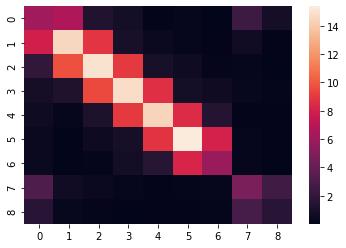

In [195]:
sns.heatmap(np.abs(y_bus - y_lasso));

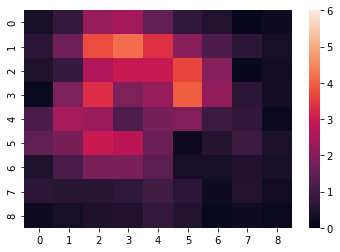

In [196]:
sns.heatmap(np.abs(y_bus - y_tls),vmin=0,vmax=6);

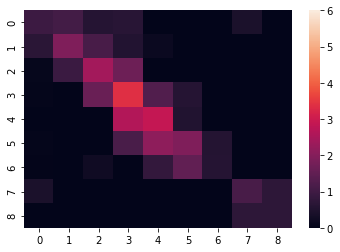

In [197]:
sns.heatmap(np.abs(y_bus - y_sparse_tls_cov),vmin=0,vmax=6);

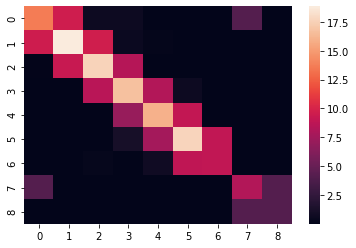

In [198]:
sns.heatmap(np.abs(y_sparse_tls_cov));